## <span style="color: white; background-color:rgb(0, 156, 217); padding:5px 20px; border-radius: 20px; font-weight:bold; font-size: 30pt">Brind TC data üåÄ</span>

In [1]:
#%%
import os
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as ticker
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups

pangu_dir = r'/data03/Pangu_TC_ENS'

pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)


#%%
#! ÌÉúÌíç Í≤ΩÎ°ú Ï†ïÎ≥¥ Í∏∞Ï°¥ Ï†ïÎ≥¥ Î∂àÎü¨Ïò§Í∏∞
#ÏúÑÍ≤ΩÎèÑ ÏßÄÏ†ï
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(100,160,5,45)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ssv_dict = {}


#ÌÉúÌíç ÏßÄÏ†ï
# storm_name, storm_year, key_time_list  = 'HINNAMNOR', 2022, ['2022/08/27/00UTC']
# storm_name, storm_year, key_time_list  = 'NORU', 2017, ['2017/07/30/00UTC']
storm_name, storm_year, key_time_list  = 'DEBBY', 2012, ['2012/06/23/00UTC']                                                                               


if storm_name == 'DEBBY':
    lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(250,310,5,45)  
    lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


surface_factors = []  # ÏòàÏãú: ÏßÄÌëúÎ©¥ÏóêÏÑúÎäî 'MSLP'Îßå ÏÑ†ÌÉù
upper_factors = ['z'] 
if storm_name == 'HINNAMNOR':
    perturation_scale = 0.05
else:
    perturation_scale = 0.1

#ÏòàÏ∏° ÏãúÍ∞Ñ ÏßÄÏ†ï, Ï¥àÍ∏∞ ÏãúÍ∞Ñ ÏßÄÏ†ï, ÏïôÏÉÅÎ∏î Ïàò
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,4000)
ens_num = len(ens_list)  # ÏïôÏÉÅÎ∏î Ïàò
new_ssv = 'n'           #ÏÉàÎ°ú ÏÉùÏÑ±Ìï† Í≤ÉÏù∏ÏßÄ Ïó¨Î∂Ä, nÏù¥Î©¥ Í∏∞Ï°¥ ÌååÏùº Î∂àÎü¨Ïò¥
retro_opt = 'td'        #Îã§Ïãú ÎèåÏïÑÍ∞ÄÎ©¥ÏÑú ÌÉúÌíç Ï∂îÏ†ÅÏãú Í∞ïÌïú Í≤ÉÎßå Ï∂îÏ†ÅÌïòÎ†§Î©¥ tdÎ°ú


if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        
#! ÌÉúÌíç Í≤ΩÎ°ú Ï†ïÎ≥¥ ÏÉàÎ°ú ÏÉùÏÑ±ÌïòÍ∏∞
if new_ssv == 'y':
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # Í∞Å ÏöîÏÜå ÏïûÏóê _ Ï∂îÍ∞Ä
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # Í∞Å ÏöîÏÜå ÏïûÏóê _ Ï∂îÍ∞Ä


        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])

        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #ÌÉúÌíç ÏòÅÎ¨∏Î™Ö, ÎÖÑÎèÑ ÏûÖÎ†•
        if any(lon < 0 for lon in storm_lon):
            storm_lon = [lon + 360 if lon < 0 else lon for lon in storm_lon]
        storm_lon = np.array(storm_lon)

        min_position = {}  # ÌÉúÌíç Ï§ëÏã¨ Ï†ïÎ≥¥ dictionary



        # for ens in range(ens_num):
        for ens in ens_list:
            print(f'{ens}Î≤àÏß∏ ÏïôÏÉÅÎ∏î ÏòàÏ∏°')
            min_position[ens] = {}
            output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
            # output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{ens}'
            
            
            
            for predict_interval in predict_interval_list:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
              
                #mask_sizeÎäî Îã§Ïùå ÌÉúÌíç Ï∞æÏùÑ Îïå Í∑∏ ÏúÑÍ≤ΩÎèÑ ÏïàÏù¥ ÏïÑÎãàÎ©¥ Ïïà Ï∞æÏùåS
                #Ï≤òÏùå ÏãúÏûëÌï† ÎïåÎäî 5ÎèÑ Ïù¥ÎÇ¥ÏóêÎßå Îì§Ïñ¥Ïò§Î©¥ ÎêòÍ≥†
                #mslp_z_disÎäî 250Ïù¥ Í∏∞Î≥∏Ïù∏Îç∞ Ïù¥Îäî mslp ÏßÄÏó≠ ÏµúÏÜüÍ∞íÍ≥º zÏßÄÏó≠ ÏµúÎåìÍ∞íÏù¥ 250km Ïù¥ÎÇ¥Ïó¨Ïïº pass
                #mslp_2hpaÎäî Ï£ºÎ≥Ä 8Î∞©ÏúÑÎ°ú 2hPaÏù¥ Í∞êÏÜåÌïòÎäîÏßÄ Î≥¥ÎäîÍ±¥Îç∞ ÏùºÎã®ÏùÄ 'n'ÏúºÎ°ú Í±∏Ïñ¥Îë†
                #ÏïÑÎûòÏóêÏÑúÎäî mask_sizeÎßêÍ≥†Îäî ÏïÑÎ¨¥Îü∞ Ï†úÏïΩÏùÑ Ïïà Í±∏ÏóàÏùå
                min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                        wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                        min_position[ens], mask_size = 2.5, init_size=5, local_min_size = 5, mslp_z_dis = 250, wind_thres=0)

            
            for predict_interval in predict_interval_list[::-1]:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
                
                if retro_opt != '_td':
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 1000, wind_thres=0)
                else:
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 250, wind_thres=0)
                    
                
                min_position[ens] = {k: min_position[ens][k] for k in sorted(min_position[ens])}
                
        ssv_dict[ssv_key] = min_position

    with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'wb') as f:
    # with open(rf'{pangu_dir}/output_data/{first_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'wb') as f:
        pickle.dump(ssv_dict, f)

else:
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # Í∞Å ÏöîÏÜå ÏïûÏóê _ Ï∂îÍ∞Ä
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # Í∞Å ÏöîÏÜå ÏïûÏóê _ Ï∂îÍ∞Ä
        
        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #ÌÉúÌíç ÏòÅÎ¨∏Î™Ö, ÎÖÑÎèÑ ÏûÖÎ†•
        if any(lon < 0 for lon in storm_lon):
            storm_lon = [lon + 360 if lon < 0 else lon for lon in storm_lon]
        storm_lon = np.array(storm_lon)
        
        with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
        # with open(rf'{pangu_dir}/output_data/{first_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
            ssv_dict = pickle.load(f)


def normalize_lon(lon):
    """Í≤ΩÎèÑÎ•º Ìï≠ÏÉÅ -180~180 ÏÇ¨Ïù¥Î°ú Î≥ÄÌôò"""
    lon = np.array(lon)
    lon = ((lon + 180) % 360) - 180
    return lon

## Draw TC data üåÄ

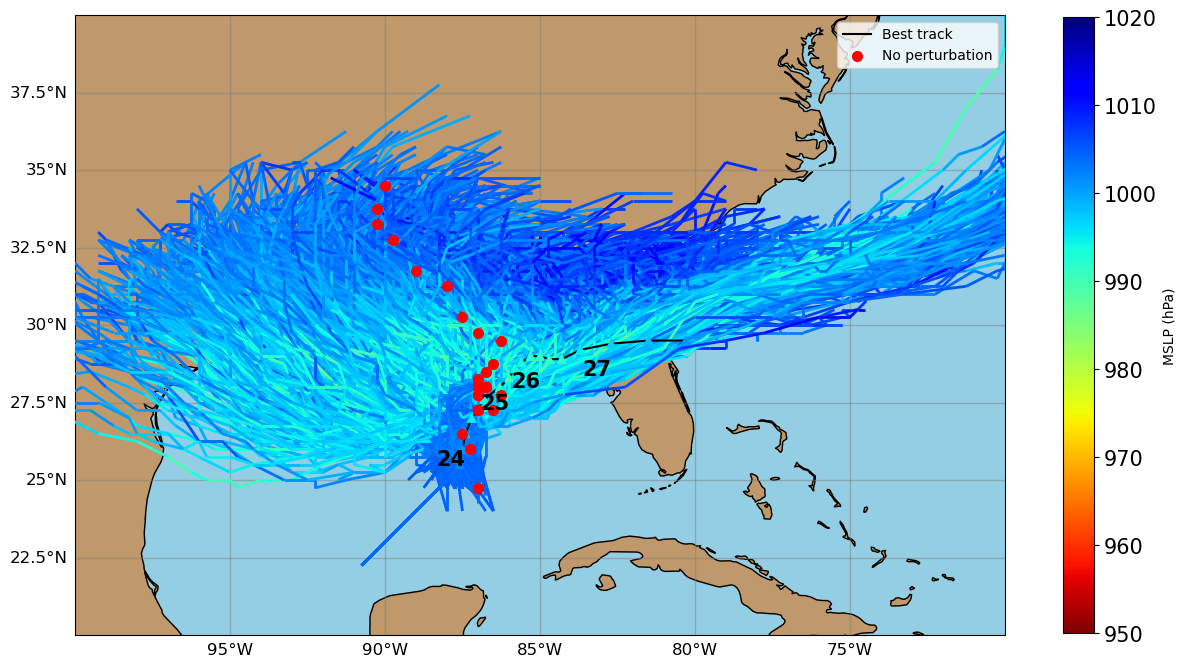

In [4]:


#! ÌÉúÌíç Í≤ΩÎ°ú Í∑∏Î¶¨Í∏∞
for key_time ,min_position in ssv_dict.items():
    fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
    key_str = key_time.strftime("%m.%d.%HUTC")
    # ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval_list[-1]}h)', fontsize=20, loc = 'left')
    # ax.set_title(f'ENS{surface_str}{upper_str}{perturation_scale} Track\n{storm_name}', fontsize=20, loc = 'right')
    # ax.set_title(f'{storm_name}', fontsize=20, loc = 'right')
    ax.set_extent([260,290,20,40], crs=proj)
    setup_map(ax)

    ax.plot(storm_lon, storm_lat, color='black', linestyle='-', marker='', label = 'Best track', transform=ax.projection, zorder=10)
    model_pred_sc = ax.scatter(storm_lon-360, storm_lat, c=storm_mslp, cmap='jet_r', marker='^',norm=norm_p, transform=ax.projection, zorder=10)
    cbar = plt.colorbar(model_pred_sc, ax=ax, orientation='vertical', label='MSLP (hPa)', shrink=0.8)
    cbar.ax.tick_params(labelsize=15)

    
    for i in range(len(storm_time)):
        new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
        if new_time.endswith('00UTC'):
            dx, dy = 5, -0.5  # ÏãúÍ∞Ñ ÎÇòÌÉÄÎÇº ÏúÑÏπò Ï°∞Ï†ï
            new_lon, new_lat = storm_lon[i] + dx, storm_lat[i] + dy
            
            # annotateÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÌÖçÏä§Ìä∏ÏôÄ Ìï®Íªò ÏÑ†(ÌôîÏÇ¥Ìëú)ÏùÑ Í∑∏Î¶º
            ax.text(storm_lon[i]-360, new_lat, new_time[8:-6]
                    , horizontalalignment='right', verticalalignment='top', fontsize=15, zorder = 20, fontweight = 'bold')



    for ens in range(ens_num):  
    # for ens in ens_list:  


        lons = [pos['lon']-360 for _,pos in min_position[ens].items()]
        lats = [pos['lat'] for _,pos in min_position[ens].items()]
        min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
        pred_times = [pos for pos,_ in min_position[ens].items()]
        # print(ens)
        lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)

        #? ÏãúÍ∞Ñ ÌëúÏãú 00UTCÎßå ÌëúÏãú, ÏóÜÏï®ÎìØ

        if ens == 0:
            lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)
            ax.scatter(lons, lats, c='red', linewidth=2, alpha=1, zorder=10, label = 'No perturbation')

            # for i in range(len(pred_times)):
            #     if pred_times[i].hour == 0:
            #         ax.text(lons[i],lats[i], str(pred_times[i].day)
            #             , horizontalalignment='center', verticalalignment='bottom', fontsize=10, zorder = 6)

        
    ax.legend(loc='upper right')


    lons_all = np.concatenate([np.array([pos['lon'] for _, pos in min_position[ens].items()]) for ens in range(ens_num)])
    lats_all = np.concatenate([np.array([pos['lat'] for _, pos in min_position[ens].items()]) for ens in range(ens_num)])


    xy = np.vstack([lons_all, lats_all])
    kde = gaussian_kde(xy)
    positions = np.vstack([lon_grid.ravel(), lat_grid.ravel()])
    f = np.reshape(kde(positions).T, lon_grid.shape)


    levels = np.linspace(0.0005, 0.015, 100)
    # cf = ax.contourf(lon_grid, lat_grid, f, levels=levels, transform=proj, cmap='jet')
    plt.show()
    fig.savefig(f'/home1/jek/Pangu-Weather/plot/{storm_name}_Ensemble_track_{key_str}.png',bbox_inches='tight')
    

## draw each ensemble data

11Î≤àÏß∏ ÏïôÏÉÅÎ∏î ÏòàÏ∏°


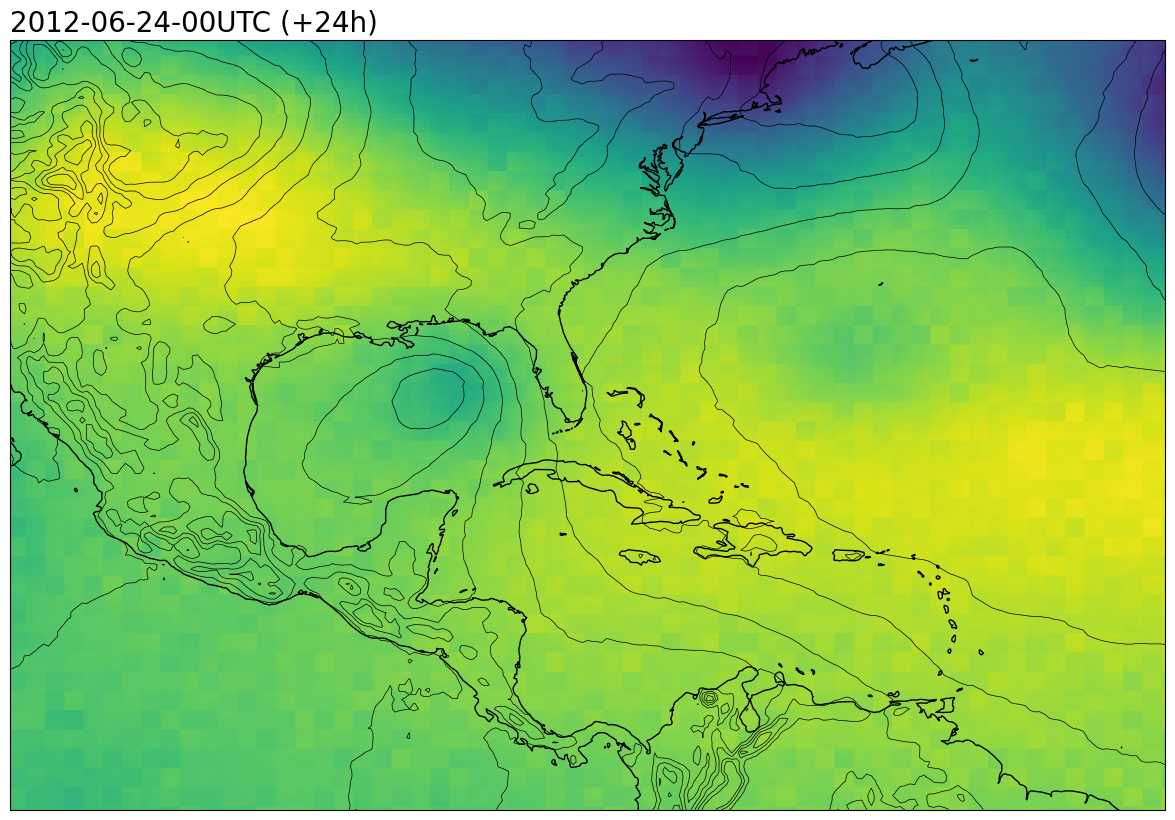

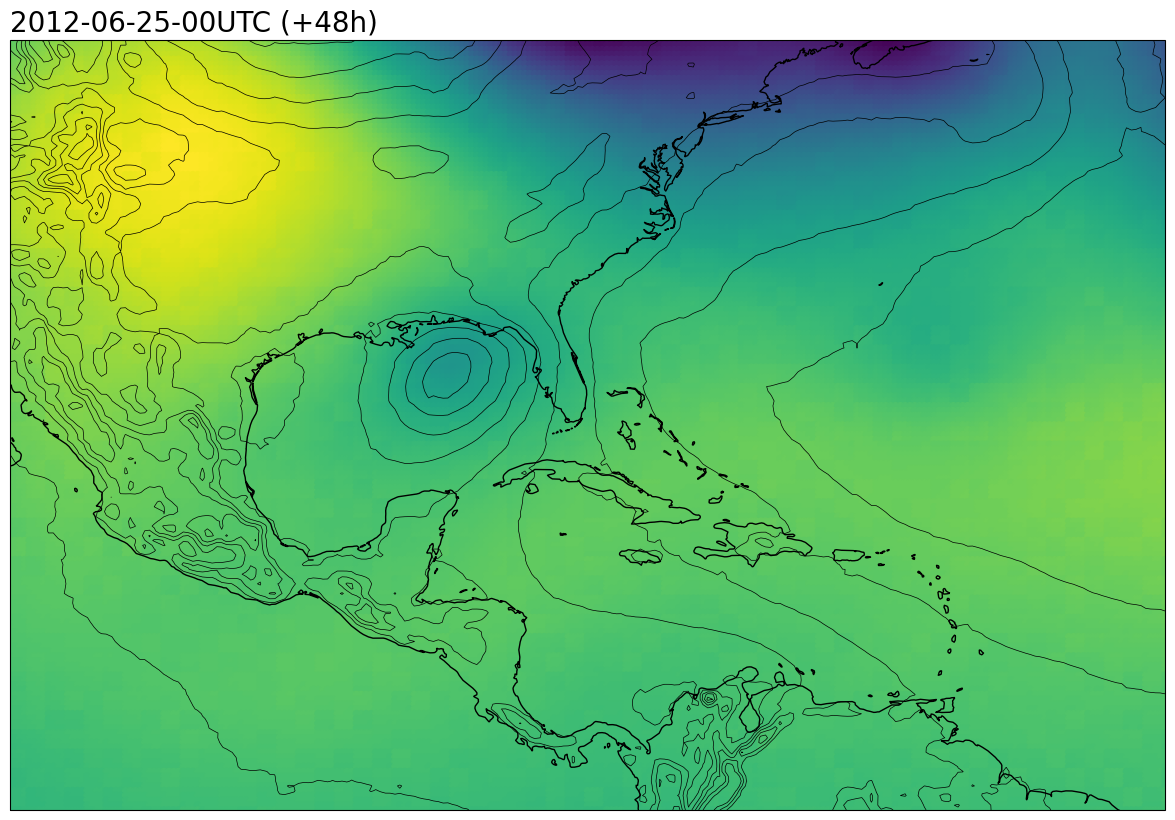

In [10]:
for ens in [11]:
    print(f'{ens}Î≤àÏß∏ ÏïôÏÉÅÎ∏î ÏòàÏ∏°')
    # min_position[ens] = {}
    output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
    # output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{ens}'
    
    
    
    # for predict_interval in predict_interval_list:
    for predict_interval in range(24, 49, 24):
        predict_time = first_time + timedelta(hours=int(predict_interval))
        predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
        met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
        u_500 = met.met_data('u', level = 500) 
        v_500 = met.met_data('v', level = 500)
        fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
        ax.set_title(f'{predict_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval}h)', fontsize=20, loc = 'left')
        # ax.streamplot(lon_grid, lat_grid, u_500, v_500, color='black', linewidth=1, density=10, transform=proj)
        # ax.set_extent([120,155,20,45], crs=proj)
        z_500 = met.met_data('z', level = 500)
        mslp = met.met_data('MSLP')
        ax.scatter(lon_grid, lat_grid, c=z_500, s=20, transform=proj)
        ax.contour(lon_grid, lat_grid, mslp, levels=np.arange(950, 1020, 2), colors='black', linewidths=0.5, transform=proj)
        # setup_map(ax)
        ax.coastlines()
        plt.show() 

    break

## Scatter each time step TC locatons

Total number of ensemble members: 84


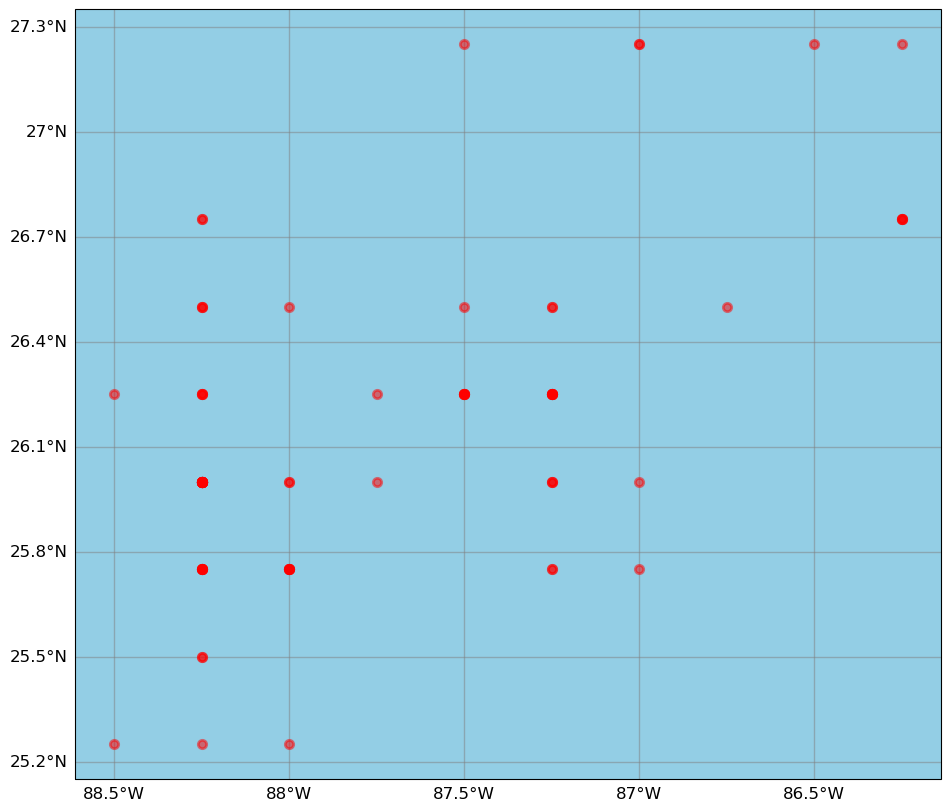

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
key_str = key_time.strftime("%m.%d.%HUTC")
# ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval_list[-1]}h)', fontsize=20, loc = 'left')
# ax.set_title(f'ENS{surface_str}{upper_str}{perturation_scale} Track\n{storm_name}', fontsize=20, loc = 'right')
# ax.set_title(f'{storm_name}', fontsize=20, loc = 'right')
# ax.set_extent([120,155,20,45], crs=proj)
setup_map(ax)
obs_time = datetime(2012, 6, 24, 0, 0)
total_num = 0

for ens in ens_list:  
    if obs_time not in min_position[ens]:
        continue


    # lons = [pos['lon'] for _,pos in min_position[ens].items()][-1]
    # lats = [pos['lat'] for _,pos in min_position[ens].items()][-1]
    # min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
    # pred_times = [pos for pos,_ in min_position[ens].items()]
    # print(ens)
    # lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)

    ax.scatter(min_position[ens][obs_time]['lon'], min_position[ens][obs_time]['lat'], c='red', linewidth=2, alpha=0.5, zorder=10, label = 'No perturbation')
    #? ÏãúÍ∞Ñ ÌëúÏãú 00UTCÎßå ÌëúÏãú, ÏóÜÏï®ÎìØ
    total_num += 1
print(f'Total number of ensemble members: {total_num}')

In [2]:
if storm_name == 'HINNAMNOR':
    key_time = datetime(2022,8,27,0)             #Ï≤òÏùå ÏãúÏ†ê ÏßÄÏ†ï
    start_time = datetime(2022,8,28,0)           #Î∂ÑÏÑù ÏãúÏûë ÏãúÏ†ê
    target_time = datetime(2022,9,1,0)           #ÏúÑÏπò projectionÏùÑ Íµ¨ÌïòÍ≥†Ïûê ÌïòÎäî ÏãúÍ∞Ñ
elif storm_name == 'NORU':
    key_time = datetime(2017,7,30,0)              #Ï≤òÏùå ÏãúÏ†ê ÏßÄÏ†ï
    start_time = datetime(2017,7,30,0)            #Î∂ÑÏÑù ÏãúÏûë ÏãúÏ†ê
    target_time = datetime(2017,8,4,0)            #ÏúÑÏπò projectionÏùÑ Íµ¨ÌïòÍ≥†Ïûê ÌïòÎäî ÏãúÍ∞Ñ
elif storm_name == 'DEBBY':
    key_time = datetime(2012,6,23,0)              #Ï≤òÏùå ÏãúÏ†ê ÏßÄÏ†ï
    start_time = datetime(2012,6,24,0)            #Î∂ÑÏÑù ÏãúÏûë ÏãúÏ†ê
    target_time = datetime(2012,6,27,0)            #ÏúÑÏπò projectionÏùÑ Íµ¨ÌïòÍ≥†Ïûê ÌïòÎäî ÏãúÍ∞Ñ

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# Î≥ÄÏàò ÏßÄÏ†ï
loc_corr_sign = 'n'                         #Í∞ÄÍπåÏö¥ ÏúÑÏπòÏóê ÎåÄÌï¥ÏÑúÎßå ÏßÑÌñâÌï† Í≤ÉÏù∏Í∞Ä
tc_remove_sign = 'y'                        #ÌÉúÌíç Ï†úÍ±∞Î•º ÏßÑÌñâÌï† Í≤ÉÏù∏ÏßÄÎ•º ÌåêÎã®
choosen_factor_list = ['z','t','q','u','v'] #Íµ¨ÌïòÍ≥†Ïûê ÌïòÎäî Î≥ÄÏàò
altitude_list = [1000,850,700,500,300,200]  #Í∞Å Î≥ÄÏàòÏóê ÎåÄÌï¥ Íµ¨ÌïòÍ≥†Ïûê ÌïòÎäî Í≥†ÎèÑ
steer_pres = [850,700,600,500,400,300,250]  #steering wind Íµ¨Ìï† Îïå ÏÇ¨Ïö©ÌïòÎäî Í≥†ÎèÑ Î∞îÍøÄ ÌïÑÏöî x
axis_opt = 'opt'                            #axis Î≠òÎ°ú Ïû°ÏùÑÏßÄ
data_sign = 'n'                             #Í∏∞Ï°¥Ïùò Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï† Í≤ÉÏù∏ÏßÄ


# tc_remove_signÏù¥ yÎ©¥ steering windÏóê ÎåÄÌï¥ÏÑúÎßå Íµ¨ÌïòÍ∏∞
if tc_remove_sign == 'y':
    altitude_list = ['850_200']
    choosen_factor_list = ['steering_wind']

# target_time ÎïåÎèÑ ÏÇ¥ÏïÑÏûàÎäî ÌÉúÌíçÎßå Ï∂îÏ∂ú
ens_num_list = []
for ens in range(ens_num):
    if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
        ens_num_list.append(ens)
print(ens_num_list, len(ens_num_list))


ens_pos = [(ens, ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
correlations = []
correlations_opt = []
correlations_df = []


def get_subdomain_indices(lat_grid, lon_grid, center_lat, center_lon, dlat=10, dlon=10):
    lat_vals = lat_grid[:, 0]
    lon_vals = lon_grid[0, :]

    lat_min = center_lat - dlat
    lat_max = center_lat + dlat
    lon_min = center_lon - dlon
    lon_max = center_lon + dlon

    i_start = np.searchsorted(lat_vals, lat_min, side='left')
    i_end   = np.searchsorted(lat_vals, lat_max, side='right')
    j_start = np.searchsorted(lon_vals, lon_min, side='left')
    j_end   = np.searchsorted(lon_vals, lon_max, side='right')
    return i_start, i_end, j_start, j_end

for predict_interval in np.arange(48,total_time_range+1,6):
# for predict_interval in np.arange(102,total_time_range+1,6):
# for predict_interval in np.arange(18,total_time_range+1,6):
# for predict_interval in np.arange(36,37,6):
# for predict_interval in np.arange(120,124,6):
    datetime1 = key_time + timedelta(hours=int(predict_interval))

    mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
    tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
    tc_pos  = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
    
    # NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    mid_pos, tar_pos, tc_pos = np.array(mid_pos), np.array(tar_pos), np.array(tc_pos)
    tc_pos_mean = np.mean(tc_pos, axis=0)
    
    # Í≤ΩÎèÑÏùò ÏôúÍ≥°ÏùÑ Î≥¥Ï†ï
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # Í≤ΩÎèÑÏóê cos(ÏúÑÎèÑ)Î•º Í≥±Ìï¥ Í±∞Î¶¨ ÏôúÍ≥° Î≥¥Ï†ï
    pca_tar = PCA(n_components=1)
    pca_tar.fit(corr_pos_tar)
    pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])

    corr_pos_mid = np.copy(mid_pos)
    corr_pos_mid[:, 0] = (mid_pos[:, 0]-np.mean(mid_pos[:, 0])) * np.cos(np.radians(mid_pos[:, 1]))  # Í≤ΩÎèÑÏóê cos(ÏúÑÎèÑ)Î•º Í≥±Ìï¥ Í±∞Î¶¨ ÏôúÍ≥° Î≥¥Ï†ï
    pca_mid = PCA(n_components=1)
    pca_mid.fit(corr_pos_mid)
    pca_mid.mean_[0] = pca_mid.mean_[0] / np.cos(np.radians(pca_mid.mean_[1])) + np.mean(mid_pos[:, 0])
    
    
    projection = pca_tar.transform(corr_pos_tar)[:, 0]  # Ï£ºÏ∂ïÏóê Ìà¨ÏòÅÎêú Îç∞Ïù¥ÌÑ∞ (1Ï∞®Ïõê)
    principal_component = pca_tar.components_[0]

    # Ìà¨ÏòÅÎêú Îç∞Ïù¥ÌÑ∞Ïùò ensemble mean Í≥ÑÏÇ∞
    ensemble_mean = np.mean(projection)

    # Í∞Å ÏïôÏÉÅÎ∏î Î©§Î≤ÑÏùò Ìà¨ÏòÅ Îç∞Ïù¥ÌÑ∞ÏôÄ ensemble mean ÏÇ¨Ïù¥Ïùò Í±∞Î¶¨ Í≥ÑÏÇ∞
    distances = projection - ensemble_mean

    # Í∞Å ÏïôÏÉÅÎ∏î Î©§Î≤ÑÏùò Í±∞Î¶¨Î•º Ï†ÄÏû•
    ensemble_distances = {ens: distance for ens, distance in enumerate(distances)}

    
    
    mid_proj = pca_mid.transform(mid_pos)
    tar_proj = pca_tar.transform(tar_pos)
    mid2tar = pca_tar.transform(mid_pos)
    mid_re = pca_mid.inverse_transform(mid_proj)
    tar_re = pca_tar.inverse_transform(tar_proj)
    tar2mid = pca_tar.inverse_transform(mid2tar)

    

    
    for choosen_factor in choosen_factor_list:
        for altitude in altitude_list:     
            ens_factor_uv=[]
            u_mean_each = []
            v_mean_each = []
            
            if data_sign == 'n':
                for ens in ens_num_list:
                    print(f'{predict_interval}h', ens)
                    center_lon, center_lat = ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']
                    
                    output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
                    met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                    

                    u_list = []
                    v_list = []
                    
                    
                    if len(steer_pres) > 1:
                        dis_cal_sign = 'y'
                        final_mask = None
                        for steer_altitude in steer_pres:
                            
                            div = met.divergence(level = steer_altitude)
                            vort = met.vorticity(level = steer_altitude)
                            vort_850 = met.vorticity(level = 850)
                            
                            if tc_remove_sign == 'y':
                                dis_cal_sign = 'n'
                                i_start, i_end, j_start, j_end = get_subdomain_indices(lat_grid, lon_grid, center_lat, center_lon, dlat=15, dlon=15)

                                lat_sub = lat_grid[i_start:i_end, j_start:j_end]
                                lon_sub = lon_grid[i_start:i_end, j_start:j_end]
                                vort_sub = vort[i_start:i_end, j_start:j_end]
                                div_sub = div[i_start:i_end, j_start:j_end]
                                ty_wind = WindFieldSolver(
                                    lat_sub, lon_sub, center_lat, center_lon,
                                    vort_sub, div_sub, max_iter = 50000, tol = 1250
                                    # ÌïÑÏöîÌïòÎã§Î©¥ vort_850_sub Îì± Ï∂îÍ∞Ä
                                    # final_mask=sub_final_mask Îì±ÎèÑ ÌïÑÏöîÌïòÎ©¥
                                )
                                u_ty_sub, v_ty_sub= ty_wind.solve()

                                # Í≥ÑÏÇ∞Ìïú Î∂ÄÎ∂ÑÎßå ÎçÆÏñ¥Ïì∞Í∏∞
                                u_tc_rm = met.met_data('u', level = steer_altitude)
                                u_tc_rm[i_start:i_end, j_start:j_end] = met.met_data('u', level = steer_altitude)[i_start:i_end, j_start:j_end] - u_ty_sub
                                v_tc_rm = met.met_data('v', level = steer_altitude)
                                v_tc_rm[i_start:i_end, j_start:j_end] = met.met_data('v', level = steer_altitude)[i_start:i_end, j_start:j_end] - v_ty_sub

                                # plt.quiver(lon_sub[::4,::4], lat_sub[::4,::4], u_ty_sub[::4,::4], v_ty_sub[::4,::4])
                                # plt.show()
                                # plt.quiver(lon_grid[::4,::4], lat_grid[::4,::4], met.met_data('u', level = steer_altitude)[::4,::4], met.met_data('v', level = steer_altitude)[::4,::4])
                                # plt.show()
                                # plt.quiver(lon_grid[::4,::4], lat_grid[::4,::4], u_tc_rm[::4,::4], v_tc_rm[::4,::4])
                                # plt.show()
                                u_list.append(u_tc_rm)
                                v_list.append(v_tc_rm)
                                # u_list.append(met.met_data('u', level = steer_altitude))
                                # v_list.append(met.met_data('v', level = steer_altitude))

                            else:
                                u_list.append(met.met_data('u', level = steer_altitude))
                                v_list.append(met.met_data('v', level = steer_altitude))
                                
                        u,v = np.zeros(np.shape(u_list[0])), np.zeros(np.shape(u_list[0]))
                        
                    
                        for i in range(len(steer_pres)-1):
                            u += (u_list[i]+u_list[i+1])/2*(steer_pres[i]-steer_pres[i+1])
                            v += (v_list[i]+v_list[i+1])/2*(steer_pres[i]-steer_pres[i+1])
                        
                        u/=np.ptp(steer_pres)
                        v/=np.ptp(steer_pres)
                        
                    else:
                        div = met.divergence(level = steer_pres[0])
                        vort = met.vorticity(level = steer_pres[0])
                        
                        if tc_remove_sign == 'y':
                            ty_wind = WindFieldSolver(lat_grid, lon_grid, center_lat, center_lon, vort, div, vort_850)
                            u_ty, v_ty = ty_wind.solve()
                            u = met.met_data('u', level = steer_pres[0]-u_ty)
                            v = met.met_data('v', level = steer_pres[0]-v_ty)
                            
                        else:
                            u = met.met_data('u', level = steer_pres[0])
                            v = met.met_data('v', level = steer_pres[0])
                    
                    u_mean_each.append(u)
                    v_mean_each.append(v)
                    # ens_factor.append(u * best_direction[0] + v * best_direction[1])
                    ens_factor_uv.append([u,v])
                    
                    if ens == 0:
                        u0 = u
                        v0 = v
                u_mean = np.mean(np.array(u_mean_each), axis=0)
                v_mean = np.mean(np.array(v_mean_each), axis=0)
                # Ensure the figure directory exists
                # fig_path = os.path.join(fig_dir, f'{altitude}hPa')
                # os.makedirs(fig_path, exist_ok=True)

                # Base path for output data
                base_output_path = os.path.join(
                    pangu_dir, 
                    'output_data', 
                    first_str, 
                    f'{perturation_scale}ENS{surface_str}{upper_str}', 
                    f'{start_str}_{target_str}_e{ens_num}'
                )

                # Paths for saving the arrays
                ens_factor_uv_path = os.path.join(base_output_path, 'ens_factor_uv')
                u_mean_path = os.path.join(base_output_path, 'u_mean')
                v_mean_path = os.path.join(base_output_path, 'v_mean')

                # Ensure all required directories exist
                os.makedirs(ens_factor_uv_path, exist_ok=True)
                os.makedirs(u_mean_path, exist_ok=True)
                os.makedirs(v_mean_path, exist_ok=True)
                
                np.save(f'{ens_factor_uv_path}/{predict_interval}h.npy', np.array(ens_factor_uv))
                np.save(f'{u_mean_path}/{predict_interval}h.npy', u_mean)
                np.save(f'{v_mean_path}/{predict_interval}h.npy', v_mean)

[0, 1, 4, 5, 6, 7, 8, 10, 11, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 122, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 194, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 214, 215, 216, 218, 219, 220, 222, 223, 225, 227, 228, 229, 231, 233, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 251, 252, 253, 255, 257, 258, 259, 260, 268, 270, 271, 2

In [8]:
np.shape(u_tc_rm)

(161, 241)

In [13]:
np.shape(lat_grid)

(161, 241)